In [1]:
import my_plotting
import markers
import importlib
import utils
import covax_constants
import GeneModules

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import numpy as np

import warnings
warnings.simplefilter("ignore")


import scanpy as sc
from datetime import datetime

import matplotlib.colors as mcolors

In [2]:
pbmc = sc.read_h5ad('adata-rna-adt-joint-1-annoted.h5ad')

In [19]:
myeloid_c = myeloid.copy()

myeloid_c = myeloid_c.raw.to_adata()

myeloid_c.raw = myeloid_c.copy()

myeloid_c = myeloid_c[:, myeloid_c.var.is_rna]

sc.pp.highly_variable_genes(myeloid_c, batch_key='library')

myeloid_c = myeloid_c[:, myeloid_c.var.highly_variable]

sc.pp.scale(myeloid_c, max_value=10)

sc.tl.pca(myeloid_c, svd_solver='arpack')

sc.external.pp.bbknn(myeloid_c, batch_key='library', n_pcs=20)

sc.tl.umap(myeloid_c, random_state=4)

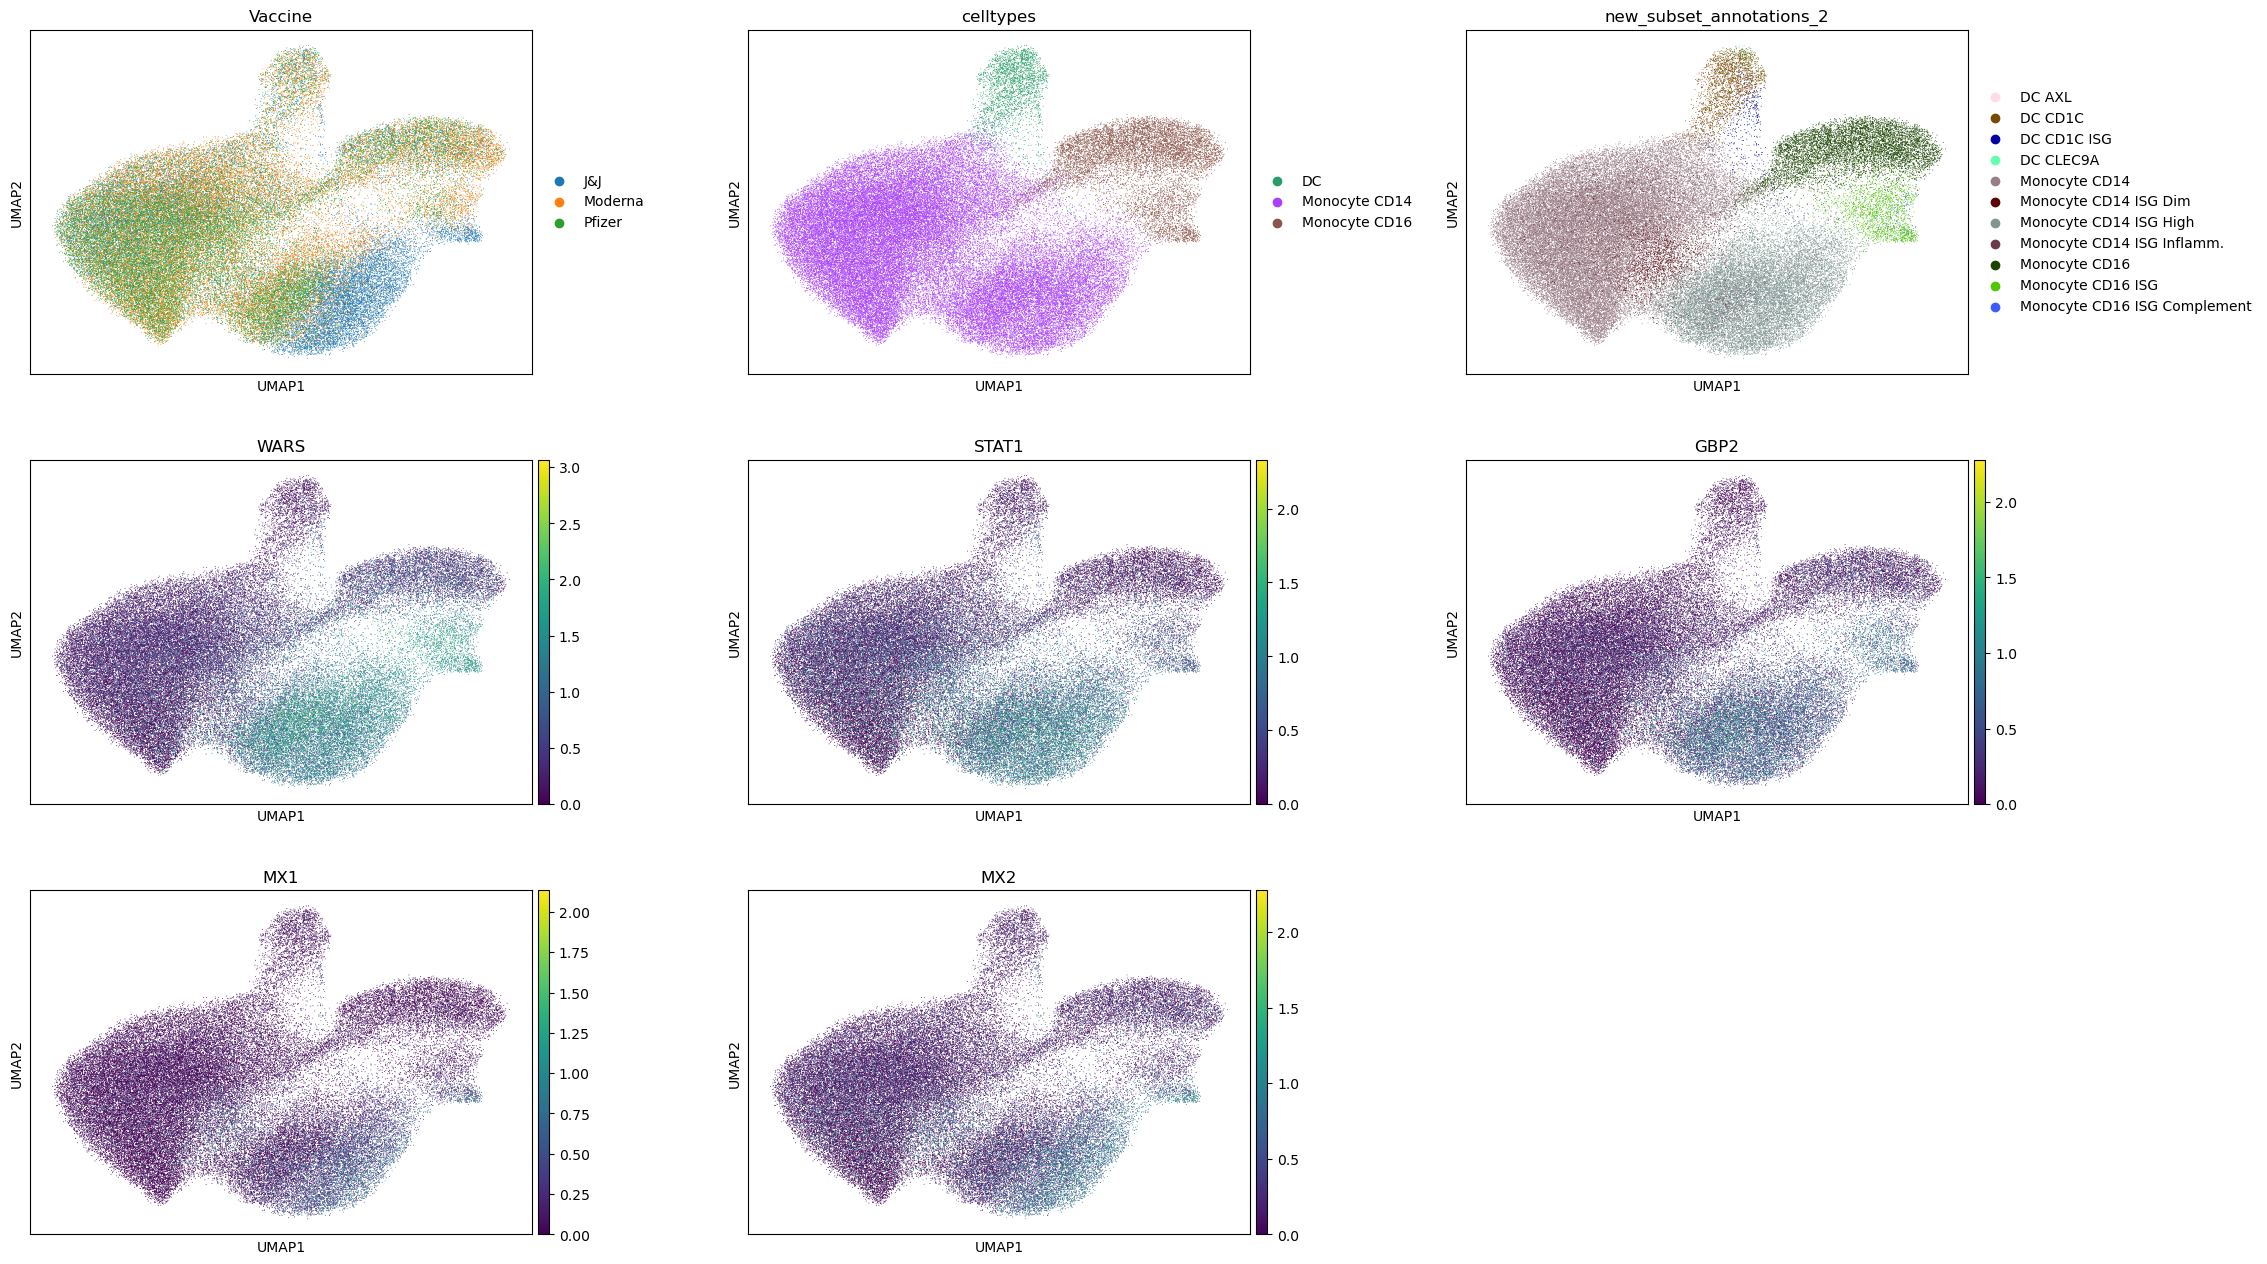

In [20]:
sc.pl.umap(myeloid_c, color =  ['Vaccine', 'celltypes', 'new_subset_annotations_2', 'WARS', 'STAT1', 'GBP2', 'MX1', 'MX2'], ncols = 3, wspace=0.3)

In [21]:
myeloid_c.write_h5ad('myeloid.h5ad')

# Load checkpoint

In [4]:
myeloid = sc.read_h5ad('myeloid.h5ad')

In [5]:
myeloid.obs['new_subset_annotations_2'] = myeloid.obs['new_subset_annotations_2'].replace({'Monocyte CD14 ISG Inflamm.' : 'Monocyte CD14 ISG High'})

In [7]:
myeloid.obs['simplified_annotations'] = pd.Categorical(myeloid.obs['new_subset_annotations_2'].map({
    "Monocyte CD14": 'CD14 ISG-',
    "Monocyte CD14 ISG Dim": 'CD14 ISG Dim',
    "Monocyte CD14 ISG High": 'CD14 ISG High',
    
    "Monocyte CD16": 'CD16 ISG-',
    "Monocyte CD16 ISG": 'CD16 ISG+',
    "Monocyte CD16 ISG Complement": 'CD16 ISG+',
    
    "DC AXL": 'DC ISG-',
    "DC CD1C": 'DC ISG-',
    "DC CLEC9A": 'DC ISG-',
    "DC CD1C ISG": 'DC ISG+',
}), categories=['CD14 ISG-', 'CD14 ISG Dim', 'CD14 ISG High', 'CD16 ISG-', 'CD16 ISG+', 'DC ISG-', 'DC ISG+'])


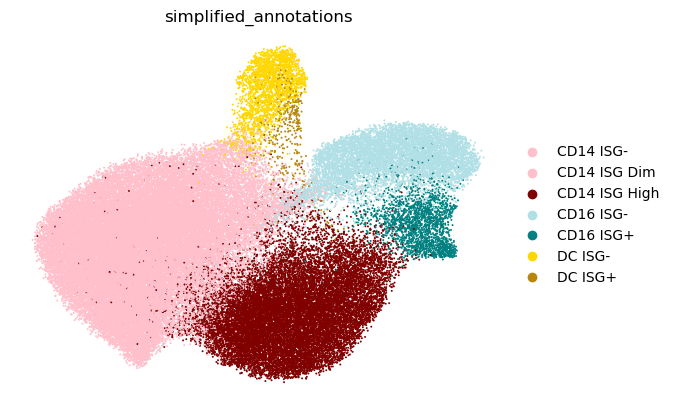

In [9]:
palette = {
    'CD14 ISG-': mcolors.CSS4_COLORS['pink'],
    'CD14 ISG Dim': mcolors.CSS4_COLORS['pink'],
    # 'CD14 ISG Dim': mcolors.CSS4_COLORS['red'],
    'CD14 ISG High': mcolors.CSS4_COLORS['maroon'],
    
    'CD16 ISG-': mcolors.CSS4_COLORS['powderblue'],
    'CD16 ISG+': mcolors.CSS4_COLORS['teal'],
    
    'DC ISG-': mcolors.CSS4_COLORS['gold'],
    'DC ISG+': mcolors.CSS4_COLORS['darkgoldenrod'],
}

fig, ax = plt.subplots(dpi=100)
sc.pl.umap(myeloid, color = ['simplified_annotations'], show=False, frameon=False, palette=palette, ax=ax, size = 8)
my_plotting.savefig_png_eps(fig, 'myeloid_subsets_umap', make_folder=True, use_timestamp=False)

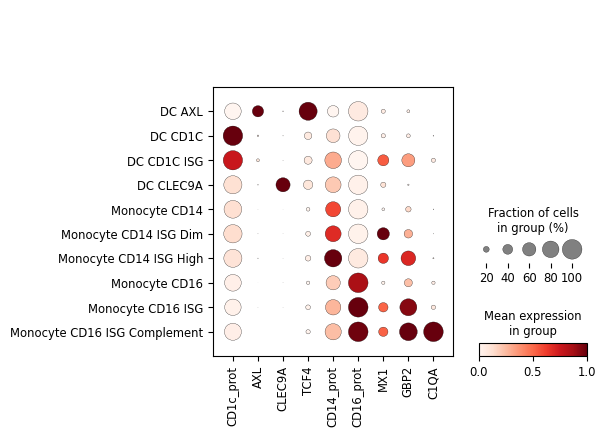

In [10]:
dp = sc.pl.dotplot(myeloid, var_names = ['CD1c_prot', 'AXL', 'CLEC9A', 'TCF4', 'CD14_prot', 'CD16_prot', 'MX1', 'GBP2', 'C1QA'], groupby='new_subset_annotations_2', return_fig = True, standard_scale='var')
dp.make_figure()
fig = dp.fig
# my_plotting.savefig_png_eps(fig, 'myeloid_subsets_dotplot', make_folder=True)

<Axes: title={'center': 'Vaccine'}, xlabel='UMAP1', ylabel='UMAP2'>

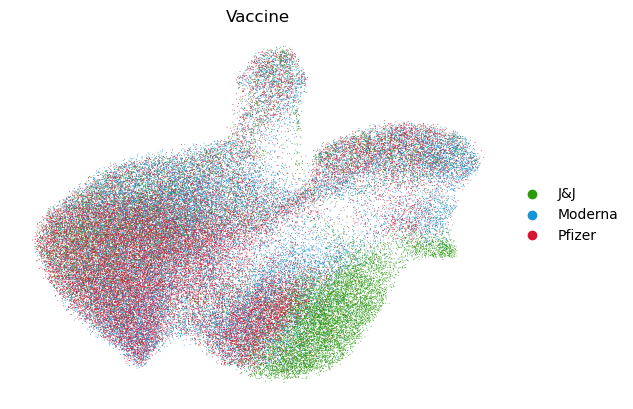

In [11]:
fig, ax = plt.subplots(dpi=100)
sc.pl.umap(myeloid, color = ['Vaccine'], show=False, frameon=False, palette=covax_constants.vax_colors, ax=ax)
# my_plotting.savefig_png_eps(fig, 'myeloid_vaccines_umap', make_folder=True)

In [12]:
pbmc = sc.read_h5ad('adata-rna-adt-joint-1-annoted.h5ad')

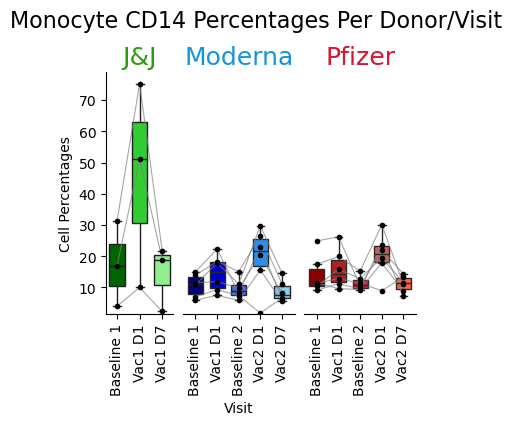

In [10]:
fig = my_plotting.cell_proportions_longitudinal_box_plot_2(pbmc_vc, 'Monocyte CD14', annots_col = 'celltypes', figsize = (4, 3.5));
# my_plotting.savefig_png_pdf_svg_eps(fig, 'CD14_monocyte_cell_proportions_longitudinal_box_plot')

In [ ]:
df = pbmc.obs.loc[pbmc.obs['celltypes']=='Monocyte CD14', ['Vaccine', 'person', 'Visit']].value_counts()
df = df/pbmc.obs[['Vaccine', 'person', 'Visit']].value_counts()
df = df.reset_index()
# display(df)

for vax in ['Moderna', 'Pfizer']:
    d1 = df.query(f"Vaccine == '{vax}' and Visit == 'Vac1 D1'").set_index('person')['count']
    bl = df.query(f"Vaccine == '{vax}' and Visit == 'Baseline 1'").set_index('person')['count']
    # res = stats.ttest_rel(bl, d1, alternative='less')
    # print(d1>bl)
    # display(res)

    res = stats.wilcoxon(bl, d1, alternative='less')
    print(d1>bl)
    display(res)

for vax in ['J&J']:
    d1 = df.query(f"Vaccine == '{vax}' and Visit == 'Vac1 D1'").set_index('person')['count']
    bl = df.query(f"Vaccine == '{vax}' and Visit == 'Baseline 1'").set_index('person')['count']
    res = stats.wilcoxon(bl, d1, alternative='less')
    print(d1>bl)
    display(res)

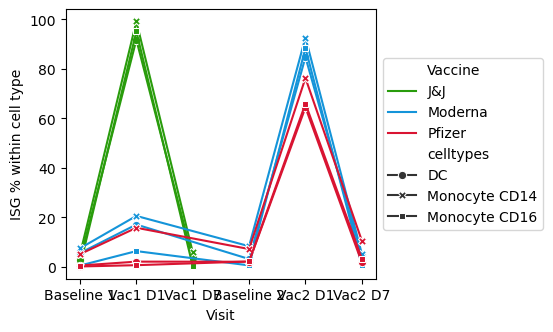

In [16]:
not_pDC = (myeloid_vc.obs.new_subset_annotations_2 != 'pDC')
perc = 100*myeloid_vc.obs.loc[myeloid_vc.obs.new_subset_annotations_2.str.contains('ISG') & not_pDC, 
                                    ['Vaccine', 'Visit', 'celltypes']].value_counts(sort=False)/myeloid_vc.obs.loc[not_pDC, ['Vaccine', 'Visit', 'celltypes']].value_counts(sort=False)
perc = perc.reset_index()

fig, ax = plt.subplots(figsize=(4, 3.5))
sns.lineplot(
    data=perc,
    x="Visit", y="count", hue="Vaccine", style="celltypes",
    markers=True, dashes=False, palette=covax_constants.vax_colors,
    ax = ax
)
ax.set_ylabel('ISG % within cell type');
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.get_legend().remove()
# my_plotting.savefig_png_eps(fig, 'lineplot_percentage_isg_myeloid', make_folder=True)

In [26]:
myeloid_vc.obs['VisitsPaper'] = myeloid_vc.obs['Visit'].map({
    'Baseline 1': 'D0V1',
    'Vac1 D1': 'D1V1',
    'Vac1 D7': 'D7V1',
    'Baseline 2': 'D0V2',
    'Vac2 D1': 'D1V2',
    'Vac2 D7': 'D7V2'
})

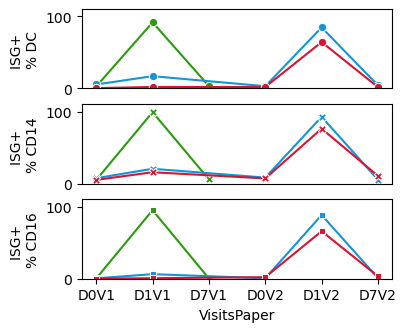

In [52]:
not_pDC = (myeloid_vc.obs.new_subset_annotations_2 != 'pDC')
perc = 100*myeloid_vc.obs.loc[myeloid_vc.obs.new_subset_annotations_2.str.contains('ISG') & not_pDC, 
                                    ['Vaccine', 'VisitsPaper', 'celltypes']].value_counts(sort=False)/myeloid_vc.obs.loc[not_pDC, ['Vaccine', 'VisitsPaper', 'celltypes']].value_counts(sort=False)
perc = perc.reset_index()

fig, axs = plt.subplots(figsize=(4, 3.5), nrows = 3)
for ax, ct in zip(axs.flat, ['DC', 'Monocyte CD14', 'Monocyte CD16']):
    sns.lineplot(
        data=perc[perc['celltypes'] == ct],
        x="VisitsPaper", y="count", hue="Vaccine", style="celltypes",
        markers=True, dashes=False, palette=covax_constants.vax_colors,
        ax = ax
    )
    ax.get_legend().remove()
    ax.set_ylim(0, 110)
    ax.set_ylabel(f'ISG+ \n% {ct.split()[-1]}')

for ax in axs.flat[:-1]:
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax.set_xlabel('')
    
my_plotting.savefig_png_eps(fig, 'lineplot_percentage_isg_myeloid', make_folder=True, use_timestamp=False)